*Composer_Model_Data_Preparation.ipynb* <p style='text-align: right;'> <b> September 20th 2020 </b> </p>
<p style='text-align: right;'> <b> David Diston </b> </p>

# Preprocess Data Required to Build a Composer Classifier LSTM RNN

***Similar data preprocessing will now need to be performed to prepare data to train a composer classifier RNN***

From the initial EDA and Visualization of my data I determined that there are 98 unique composers in the dataset. This is far too many composers for a reasonable classifier. Additionally several composers have very few peices in the dataset, which would make it extremely difficult to have balanced classes for training. Therefore I have made the decision to work only with the top 10 most occuring composers in the dataset. I will import my data csv to determine which composers are the top 10.

In [2]:
# As usual I will import my required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mido
from mido import MidiFile, MidiTrack, Message, MetaMessage
import os
import random
import shutil

In [20]:
# Read in the dataset csv
data = pd.read_csv('midi_files.csv')

In [21]:
# Confirm that the dataset was loaded correctly
data.head()

,Composer,Performer,Perf_Nationality,Perf_Gender,Piece,Length,Tempo,Time_Signature,Freq_C,Freq_C#/Db,...,Freq_F#/Gb,Freq_G,Freq_G#/Ab,Freq_A,Freq_A#/Bb,Freq_B,Unique_Velocities,Average_Velocity,Min_Velocity,Max_Velocity
0,Albeniz,JieChen,China,F,TrianaFromIberia,299,215,4/4,0.07603,0.14623,...,0.12477,0.03364,0.12954,0.09272,0.03709,0.08159,109,64.54,6,118
1,Albeniz,InesaSinkevych,Israel,F,TrianaFromIberia,261,210,4/4,0.07430,0.14861,...,0.12023,0.03612,0.12822,0.09056,0.03689,0.08127,100,70.56,6,108
2,Albeniz,AndrewStaupe,USA,M,EvocationsFromIberia,324,198,4/4,0.05186,0.10722,...,0.08479,0.08059,0.12964,0.03013,0.10652,0.08199,97,49.84,3,101
3,Albeniz,GregoryDeTurck,USA,M,RondenaFromIberia,412,187,4/4,0.07866,0.06898,...,0.08337,0.10521,0.04467,0.13201,0.06973,0.06725,116,67.68,3,119
4,Albeniz,GregoryDeTurck,USA,M,Iberia,1246,196,4/4,0.08401,0.08824,...,0.08480,0.10109,0.07221,0.09783,0.06041,0.07793,115,63.29,3,117


In [22]:
# Reconfirm the total number of unique composers in the dataset
len(data['Composer'].value_counts())

98

In [23]:
# Make a dataframe of the composer occurence frequency in order to plot
composers = data['Composer'].value_counts().to_frame()

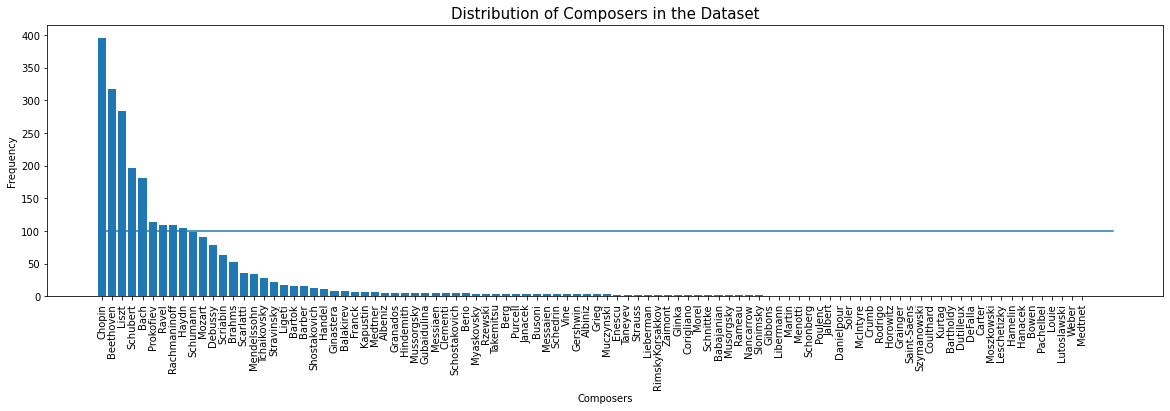

In [24]:
# Plot the frequency with which each composer appears in the dataset
plt.figure(figsize = (20,5))
plt.bar(composers.index, composers['Composer'])
plt.plot([0,100], [100,100])
plt.xticks(rotation = 'vertical')
plt.xlabel('Composers')
plt.ylabel('Frequency')
plt.title('Distribution of Composers in the Dataset', fontsize = 15)
plt.show()

Now I will identify the top 10 occuring composers in the dataset.

In [25]:
# Here I will identify the most frequent composers and how many observations in the data there are of each
composers.head(10)

,Composer
Chopin,396
Beethoven,318
Liszt,283
Schubert,197
Bach,181
Prokofiev,114
Ravel,109
Rachmaninoff,109
Haydn,105
Schumann,98


In [26]:
# I will create a new dataframe of just the top 10 composers
top_composers = composers.head(10)

In [27]:
# Here I will calculate the total number of observations present among all the top composers
top_composers_files = sum(top_composers['Composer'])
top_composers_files

1910

In [28]:
# Here I will calculate the proportion of the dataset accounted for by just the top 10 composers
print(f'The top 10 composers account for {top_composers_files / data.shape[0] * 100}% of all midi files in the dataset')

The top 10 composers account for 73.8306919211442% of all midi files in the dataset


The top 10 most frequent composers in the dataset account for over 73% of all performance files in the dataset. This indicates that a classifier of 10 classes is a reasonable representation of the dataset I have obtained. Now that I know which composers I will be classifying for, I can move all of the relevant files into a new `Composers` directory. This will be done outside of python in the file explorer (for evaluation of this project, this step has already been performed, and the directory structure created).

Now I am ready for the preprocessing of the data. As with the previous model, the first step in data preprocessing is to quantize (bin) all of the pertinent performance files. For the first model, I quantized the human performance files to the nearest 32nd note with a quantization of '8'. In order to increase the musical data I am able to include in the eventual 100 row long array clips, I will instead quantize the midi files to the nearest 16th note, using the quantization value of '4'.

As opposed to the first model data preprocessing, all preprocessing will be done inline in this one notebook before starting a new notebook for the modeling process.

In [41]:
'''********************************************'''
quantization = 4
'''********************************************'''

# Create a count of all files processed
file_count = 0

# I will iterate over all composer folders in the Composers directory
for folder in os.listdir('Composers/Composers/'):

    # Within each composer folder, I will iterate over each file 
    for file in os.listdir(f'Composers/Composers/{folder}/'):

        # I will start by importing each midi file as a mido object
        clip = MidiFile(f'Composers/Composers/{folder}/{file}')
        
        # Using the quantization value, I can calculate the time ticks per beat quantization
        ticks_per_quant = int(clip.ticks_per_beat / quantization)
        assert clip.ticks_per_beat % quantization == 0, 'ERROR: Quantization if too Fine.'

        # Instantiate my counting variables for keeping track of time
        cum_time = 0
        btw_note = 0

        # This loop will return the message number of the first note_on message
        for note_msgs, msg in enumerate(clip.tracks[0]):
            if msg.type == 'note_on':
                break
        # This variable will identify the note that switched from one quantization bin to the next
        switch = False

        # Here I will iterate over all messages starting with the first note_on message found above
        for msg in clip.tracks[0][note_msgs:]:

            # All times are time deltas, so I will create a cumulative time variable
            cum_time += msg.time

            # Here I am using the time ticks per quantum and the cumulative time to bin each note
            '''
            If the remainder of cum_time/ticks_per_quant is less than 75% of the distance from one quantization 
            to the next, then the note is binned with a time delta of 0 (back to the previous beat).
            If the remainder is greater than 75% and switch is false, then the message time delta will be set
            to the number of ticks per quant (bin size), and switch will be set to true (binned to the next beat).
            The switch variable will ensure that only the first note of all notes falling between > 75% of
            a quantum, and the next quantum will be coded with the new quantum time.
            Once the new quantum time delta has been established, all other note_on messages will be binned
            with a time delta of zero.
            '''
            if (cum_time % ticks_per_quant) <= (ticks_per_quant * 0.5):
                msg.time = 0
                switch = False

            elif (cum_time % ticks_per_quant) > (ticks_per_quant * 0.5) and switch == False:
                msg.time = int(ticks_per_quant)
                switch = True

            elif (msg.type == 'note_on'):
                msg.time = 0

        # Since time deltas have been changed as a function of the quantization, the time must be ajusted
        # to maintain the original tempo
        for msg in clip.tracks[0][note_msgs:]:
            msg.time = int(msg.time * (quantization / 4))

        # Before saving, I want to make sure that all times less than the quantization time are set to an
        # integer value of zero
        # This will also bin all note_off messages back to the nearest bin (16th note)
        for msg in clip.tracks[0][note_msgs:]:
            if msg.time < int((ticks_per_quant) * (quantization / 4) - 1):
                msg.time = int(0)

        # Here I save the new quantized midi file
        clip.save(filename = f'Composers/Composer_Quantized_Midi/{folder}/{file}')

        file_count += 1    
        print(f'Processed {file_count} files.', end = '\r')
    
print('\nDone')

Processed 1907 files.
Done


Now that each midi file has been quantized (binned) to the nearest 16th note, I need to convert each midi file to a numpy array.

In [52]:
# Instantiate a counting variable for output message
file_count = 0

# Iterate over all composer folders in the Composer_Quantized_Midi directory
for folder in os.listdir('Composers/Composer_Quantized_Midi/'):

    # Iterate over each file in each composer folder
    for file in os.listdir(f'Composers/Composer_Quantized_Midi/{folder}'):

        # Create another mido object of each quantized midi file
        clip = MidiFile(f'Composers/Composer_Quantized_Midi/{folder}/{file}')

        # Once again I will find the first note message since meta data will be ignored when creating the array
        for note_msgs, msg in enumerate(clip.tracks[0]):
            if msg.type == 'note_on':
                break

        # I will instantiate a list to hold all time steps
        track_list = []
        # I will also instantiate my new time_step list of 88 zeros (one for each piano key)
        time_step = [0] * 88
        
        # I will iterate over every midi message starting with the first note message
        for msg in clip.tracks[0][note_msgs:]:
            
            # If the new time bin (time > 0) starts with a non-note message, the current time_step will be appended
            # and a blank time_step will be instantiated
            if (msg.type != 'note_on') and (msg.type != 'note_off') and (msg.time > 0):  
                track_list.append(time_step)
                time_step = [0] * 88
            
            # If the new time bin (time > 0) starts with a note message, the current time_step will be appended to
            # the track list, and a new time_step will be instantiated
            # This note will then be inserted into the newly instantiated time_step list at its note index
            elif (msg.type == 'note_on' or msg.type == 'note_off') and (msg.time > 0):
                track_list.append(time_step)
                time_step = [0] *88
                note = (msg.note - 21)
                time_step[note] = msg.velocity
            
            # If the message is a note message, and the time step is zero, this note velocity will be
            # input into the time_step list at the index of the note number
            elif (msg.type == 'note_on' or msg.type == 'note_off') and (msg.time == 0):
                note = (msg.note - 21)
                time_step[note] = msg.velocity

        # I will append any remaining partial bin to the track list
        if sum(time_step) > 0:
            track_list.append(time_step)
        else:
            pass

        # Here I will convert my list of time_step lists to an array
        track_array = np.array(track_list)
        name = file[: -4] + '.npy'
        
        # After changing the file extention, I will save the new array created for each midi file
        np.save(f'Composers/Composer_Arrays/{folder}/{name}', track_array)

        file_count += 1    
        print(f'Processed {file_count} arrays.', end = '\r')
        
print('\nDone')

Again, because of the clip sampling that will be coming shortly, I must avoid data leakage into the validation and test sets. Therefore, these sets will be separated out now prior to random clip sampling.

In [3]:
files_moved = 0

# I will iterate over each folder (Humand/Computer) within the directory
for folder in os.listdir('Composers/Composer_Arrays/'):

    # Here I will count the number of files in the folder, and identify 10% of that number
    num_files = len(os.listdir(f'Composers/Composer_Arrays/{folder}/'))
    num_files_test = int(num_files / 10) # Used for selecting 10% of data
    
    # For 10% of the files in the folder, I will randomly select and move this 10% to the validation folder
    for i in range (0, num_files_test):
        file = random.choice(os.listdir(f'Composers/Composer_Arrays/{folder}/'))
        shutil.move(f'Composers/Composer_Arrays/{folder}/{file}', f'Composers/Composer_Test_Set_Arrays/{folder}/{file}')
        
        files_moved += 1    
        print(f'Moved {files_moved} arrays into the test set.', end = '\r')
    
    # For 10% of the files in the folder, I will randomly select and move this 10% to the test folder
    for i in range (0, num_files_test):
        file = random.choice(os.listdir(f'Composers/Composer_Arrays/{folder}/'))
        shutil.move(f'Composers/Composer_Arrays/{folder}/{file}', f'Composers/Composer_Validation_Set_Arrays/{folder}/{file}')
        
        files_moved += 1    
        print(f'Moved {files_moved} arrays into the validation set.', end = '\r')
        
print('\nDone')

Moved 294 arrays into the validation set.
Done


Now that my validation and test sets have been split from the training set, I can randomly sample array clips of 100 row length from the arrays in each of the training, validation, and test sets. These samplings will be performed separately below.

#### Training Set Sampling

In [4]:
count = 0

# I will iterate through each composer file in the composer array directory
for folder in os.listdir('Composers/Composer_Arrays/'):

    # I will create 5000 array clips for every composer (50,000 array clips total)
    for i in range(0, 5000):
        
        # I will start by selecting and loading a file at random for the current composer file
        file = random.choice(os.listdir(f'Composers/Composer_Arrays/{folder}/'))
        # I will also instantiate a new name
        name = ''
        array = np.load(f'Composers/Composer_Arrays/{folder}/{file}')

        # I will randomly select a 100 row length sample from each array for modeling
        # I will do this by randomly selecting a starting row from the length of the array less 100 rows
        length = (len(array) - 100)
        start = random.randint(0, length)
        end = start + 100
        array = array[start: end]

        # I will create a new file name and save the array clip
        name = 'CLIP--' + str(count) + '--' + file
        np.save(f'Composers/Composer_Data/{folder}/{name}', array)

        count += 1    
        print(f'Processed {count} array clips.', end = '\r')
        
print('\nDone')

Processed 50000 array clips.
Done


#### Test Set Sampling

In [5]:
count = 0

# Similarly I will complete the above process for the test set
for folder in os.listdir('Composers/Composer_Test_Set_Arrays/'):

    # For the test set I will create 500 sample clips
    for i in range(0, 500):
        # I will randomly select an array from the test folder
        file = random.choice(os.listdir(f'Composers/Composer_Test_Set_Arrays/{folder}/'))
        name = ''
        # Load each array
        array = np.load(f'Composers/Composer_Test_Set_Arrays/{folder}/{file}')

        # I will randomly select a 100 length sample from each array for modeling
        length = (len(array) - 100)
        start = random.randint(0, length)
        end = start + 100
        array = array[start: end]

        # I will create a new file name and save the array clip
        name = 'TEST_CLIP--' + str(count) + '--' + file
        np.save(f'Composers/Composer_Test_Set_Data/{folder}/{name}', array)

        count += 1    
        print(f'Processed {count} array clips.', end = '\r')
        
print('\nDone')

Processed 5000 array clips.
Done


#### Validation Set Sampling

In [6]:
count = 0

# And once again for the validation set (iterate over each composer folder)
for folder in os.listdir('Composers/Composer_Validation_Set_Arrays/'):

    # Once again I will create 500 validation samples for each composer
    for i in range(0, 500):
        file = random.choice(os.listdir(f'Composers/Composer_Validation_Set_Arrays/{folder}/'))
        name = ''
        # Load each array
        array = np.load(f'Composers/Composer_Validation_Set_Arrays/{folder}/{file}')

        # I will randomly select a 100 length sample from each array for modeling
        length = (len(array) - 100)
        start = random.randint(0, length)
        end = start + 100
        array = array[start: end]

        # I will create a new file name and save the array clip
        name = 'VAL_CLIP--' + str(count) + '--' + file
        np.save(f'Composers/Composer_Validation_Set_Data/{folder}/{name}', array)

        count += 1    
        print(f'Processed {count} array clips.', end = '\r')
        
print('\nDone')

Processed 5000 array clips.
Done


I have now completed all my required data preprocessing in order to build and train my new composer classification model.

<p style='text-align: right;'> <b> Next Step: </b> Build RNN for Composer Classification - <em> RNN_Model_Composers.ipynb </em> </p>